### Model Ivar using sky

In [21]:
import numpy as np
from pathlib import Path
from astropy.io import fits
from astropy.table import Table, vstack, hstack, unique,join
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import sys

# sys.path.append("/global/u2/b/bid13/VI/prospect/py")

import desispec.coaddition
import desispec.io
import desispec.spectra
# from desitarget.cmx.cmx_targetmask import cmx_mask
from desitarget.sv1.sv1_targetmask import desi_mask
from prospect import utilities,plotframes, myspecselect, myspecupdate
from scipy.interpolate import interp1d
from scipy.ndimage import median_filter
from scipy.stats import binned_statistic
from desispec.coaddition import coadd_cameras
from prospect import utilities ,plotframes
# from prospect_my import plotframes
from bokeh.plotting import figure, show, save
from bokeh.io import output_notebook
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from astropy.modeling import models, fitting
output_notebook()
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoCV

sys.path.append("../")
from importlib import reload
import stack_spectra
import spectral_resampling
reload(spectral_resampling)
reload(stack_spectra)

Loading BokehJS ...

<module 'stack_spectra' from '../stack_spectra.py'>

In [67]:
my_path = Path("/global/cscratch1/sd/bid13/stack_spectra")
file_name = "ELG_1.0_1.1_v0.npz"

In [68]:
data = np.load(my_path / file_name)

In [69]:
flux = data["flux"]
ivar = data["ivar"]
wave = data["wave"]
z_table = data["z_table"]

sky_ivar = data["sky_ivar"]

In [70]:
sky_mask = np.any(np.isfinite(1/sky_ivar), axis=-1)

<ipython-input-70-920d6f407709>:1: RuntimeWarning: divide by zero encountered in true_divide
  sky_mask = np.any(np.isfinite(1/sky_ivar), axis=-1)


In [71]:
flux = flux[sky_mask]
ivar = ivar[sky_mask]
z_table = z_table[sky_mask]

sky_ivar = sky_ivar[sky_mask]

In [72]:
# wave_new = stack_spectra._redshift(wave, z_table["Z"], 0, "wave")

In [73]:
ivar_model = stack_spectra.model_ivar(ivar, sky_ivar, wave)

../stack_spectra.py:309: RuntimeWarning: divide by zero encountered in true_divide
  sky_var = 1 / sky_ivar
../stack_spectra.py:329: RuntimeWarning: divide by zero encountered in true_divide
  obj_var = 1 / (ivar[i])
../stack_spectra.py:329: RuntimeWarning: divide by zero encountered in true_divide
  obj_var = 1 / (ivar[i])
../stack_spectra.py:329: RuntimeWarning: divide by zero encountered in true_divide
  obj_var = 1 / (ivar[i])
../stack_spectra.py:329: RuntimeWarning: divide by zero encountered in true_divide
  obj_var = 1 / (ivar[i])
../stack_spectra.py:329: RuntimeWarning: divide by zero encountered in true_divide
  obj_var = 1 / (ivar[i])
../stack_spectra.py:329: RuntimeWarning: divide by zero encountered in true_divide
  obj_var = 1 / (ivar[i])
../stack_spectra.py:329: RuntimeWarning: divide by zero encountered in true_divide
  obj_var = 1 / (ivar[i])
../stack_spectra.py:329: RuntimeWarning: divide by zero encountered in true_divide
  obj_var = 1 / (ivar[i])
../stack_spectra.py:

In [74]:
flux, ivar, wave = stack_spectra._common_grid(flux, wave, ivar_model, z_table["Z"])

../spectral_resampling.py:278: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(1 / ivar)


In [75]:
flux_normed, ivar_normed = stack_spectra._normalize(flux, ivar)

In [76]:
ivar_fin = ivar/ np.nanmedian(ivar, axis=1, keepdims=True)
# ivar_fin = ivar_normed/ np.nanmedian(ivar_normed, axis=1, keepdims=True)

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


In [77]:
avg = np.nansum(flux*ivar_fin, axis=0)/np.nansum(ivar_fin, axis=0)

<ipython-input-77-603f845baa33>:1: RuntimeWarning: invalid value encountered in true_divide
  avg = np.nansum(flux*ivar_fin, axis=0)/np.nansum(ivar_fin, axis=0)


In [ ]:
# hdu = fits.open("/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/redrock-templates/master/rrtemplate-galaxy.fits")
# flux_t = hdu[0].data
# dw = 0.1
# wave_t = np.arange(3500/(1+1.85), 11000+dw/2, dw)

In [ ]:
# x1 = 299792458*(wave - 3728.8)/(1000*wave)
# x2 = 299792458*(wave - 2802.71)/(1000*wave)

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(10,6), sharex=True)
# ax = np.ravel(ax)
# # oII_mask = (wave>3700) & (wave<3750)
# mgII_mask = (wave>2770) & (wave<2820)
# # ax[0].plot(x1[oII_mask], avg[oII_mask])
# ax[0].plot(wave[mgII_mask],avg[mgII_mask], lw=2, label="Stacked Data")
# ax[0].axvline(2795.5, c="k", ls="--", label="Expected Location")
# ax[0].axvline(2802.7, c="k", ls="--")
# ax[0].set_xlabel(r"Wavelength ($\AA$)", size=20)
# ax[0].set_ylabel(r"Normalized Flux", size=20)
# plt.title("Location of MgII absorption lines", size=20)
# plt.savefig("../../figs/mgII.jpg")
# plt.legend()

In [ ]:
# p = figure(title="Spectra", x_axis_label='Wavelength', y_axis_label='Flux', plot_width=1000, plot_height=300, tooltips=[("Wavelength", "$x"), ("Flux", "$y")]
# #            y_range=(-1, 3)
#           )
# p.line(wave, avg, legend_label="Temp.", line_width=2)

# show(p)

In [78]:
gmag =  22.5 - 2.5 * np.log10(z_table["FLUX_G"])
gmag = gmag - (3.214*z_table["EBV"])
g_flux = 10**((22.5-gmag)/2.5)

In [79]:
flux_mask = (g_flux>=0.25) & (g_flux<=1.25)

In [80]:
nbins=5
nbootstraps = 1000
out, bins = pd.qcut(g_flux[flux_mask], nbins, labels=False, retbins=True)

In [81]:
mgII_mask1 = (wave>2792.5) & (wave<2796.5)
mgII_mask2 = (wave>2800) & (wave<2804.5)
loc1 = np.zeros(nbins)
loc1_boot = np.zeros((nbins, nbootstraps))
loc2 = np.zeros(nbins)
loc2_boot = np.zeros((nbins, nbootstraps))
stack = np.zeros((5, flux.shape[1]))
for i in range(nbins):
    bin_mask = (out==i)
    flux_bin = flux[flux_mask][bin_mask]
    ivar_bin = ivar_fin[flux_mask][bin_mask]
    avg_bin = np.nansum(flux_bin*ivar_bin, axis=0)/np.nansum(ivar_bin, axis=0)
    stack[i] = avg_bin
    
    
#     x= wave[mgII_mask1]
#     y = avg_bin[mgII_mask1]
    
#     line = models.Polynomial1D(2)
#     fit_g = fitting.LinearLSQFitter()
#     g = fit_g(line, x, y)
#     loc1[i]=-1*g.c1/(2*g.c2)
    
#     x= wave[mgII_mask2]
#     y = avg_bin[mgII_mask2]
    
#     line = models.Polynomial1D(2)
#     fit_g = fitting.LinearLSQFitter()
#     g = fit_g(line, x, y)
#     loc2[i]=-1*g.c1/(2*g.c2)
    
    
#     #Booty-booty strappy-strappy
#     n_obj_bin = len(flux_bin)
#     for j in range(nbootstraps):
#         idx = np.random.choice(n_obj_bin, n_obj_bin, replace=True)
#         flux_boot = flux_bin[idx]
#         ivar_boot = ivar_bin[idx]
        
#         avg_boot = np.nansum(flux_boot*ivar_boot, axis=0)/np.nansum(ivar_boot, axis=0)
#         x= wave[mgII_mask1]
#         y = avg_boot[mgII_mask1]

#         line = models.Polynomial1D(2)
#         fit_g = fitting.LinearLSQFitter()
#         g = fit_g(line, x, y)
#         loc1_boot[i,j]=-1*g.c1/(2*g.c2)

#         x= wave[mgII_mask2]
#         y = avg_boot[mgII_mask2]

#         line = models.Polynomial1D(2)
#         fit_g = fitting.LinearLSQFitter()
#         g = fit_g(line, x, y)
#         loc2_boot[i,j]=-1*g.c1/(2*g.c2)
        
#         print(f"{i*j}", end="\r")
np.savez(my_path/("stacks"+file_name), stack=stack, wave=wave)

<ipython-input-81-d040b8b4f232>:12: RuntimeWarning: invalid value encountered in true_divide
  avg_bin = np.nansum(flux_bin*ivar_bin, axis=0)/np.nansum(ivar_bin, axis=0)


In [17]:
v1 = 3e5*(loc1-2795.5)/2795.5
s1 = 3e5*(loc1_boot-2795.5)/2795.5
v2 = 3e5*(loc2-2802.7)/2802.7
s2 = 3e5*(loc2_boot-2802.7)/2802.7

In [18]:
def better_step(bin_edges, y, yerr=None, ax=None, **kwargs):
    """A 'better' version of matplotlib's step fn_objion
    
    Given a set of bin edges and bin heights, this plots the thing
    that I wish matplotlib's ``step`` command plotted. All extra
    arguments are passed directly to matplotlib's ``plot`` command.
    
    Args:
        bin_edges: The bin edges. This should be one element longer than
            the bin heights array ``y``.
        y: The bin heights.
        ax (Optional): The axis where this should be plotted.
    
    """
    new_x = np.array([a for row in zip(bin_edges[:-1], bin_edges[1:]) for a in row])
    new_y = np.array([a for row in zip(y, y) for a in row])
    
    if ax is None:
        ax = plt.gca()
   
    if yerr is not None:
        p = ax.plot(new_x, new_y, **kwargs)
        new_yerr = np.array([a for row in zip(yerr, yerr) for a in row])
        ax.fill_between(new_x, new_y+new_yerr, new_y-new_yerr, alpha=0.1, color= p[0].get_color())
    return ax

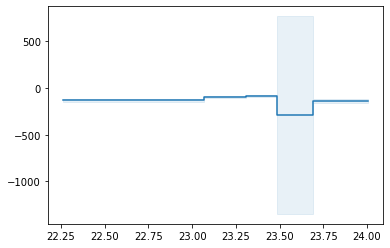

In [19]:
mag_bins = 22.5 - 2.5*np.log10(bins)
better_step(mag_bins, (v1+v2)/2, np.std((s1+s2)/2, axis=-1))

In [20]:
np.savez(my_path/("results"+file_name), v1=v1, v2=v2, s1=s1, s2=s2, mag_bins=mag_bins)

In [ ]:
plt.hist(g_flux, bins=100, range=(0,2))
plt.xlabel("g_flux")
plt.show()

In [ ]:
np.quantile(g_flux,0.90)

In [ ]:
mgII_mask1 = (wave>2792.5) & (wave<2796.5)
mgII_mask2 = (wave>2800) & (wave<2804.5)

In [ ]:
x= wave[mgII_mask1]
y = avg[mgII_mask1]

In [ ]:
line = models.Polynomial1D(2)
# fit_g = fitting.LevMarLSQFitter()
# fit_g = fitting.SLSQPLSQFitter()
fit_g = fitting.LinearLSQFitter()
g = fit_g(line, x, y)

# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko')
x_p = np.linspace(x.min(), x.max(),100)
plt.plot(x_p, g(x_p))
plt.xlabel('wavelength')
plt.ylabel('Flux')
print(f"peak: {-1*g.c1/(2*g.c2)}")

# Make plots

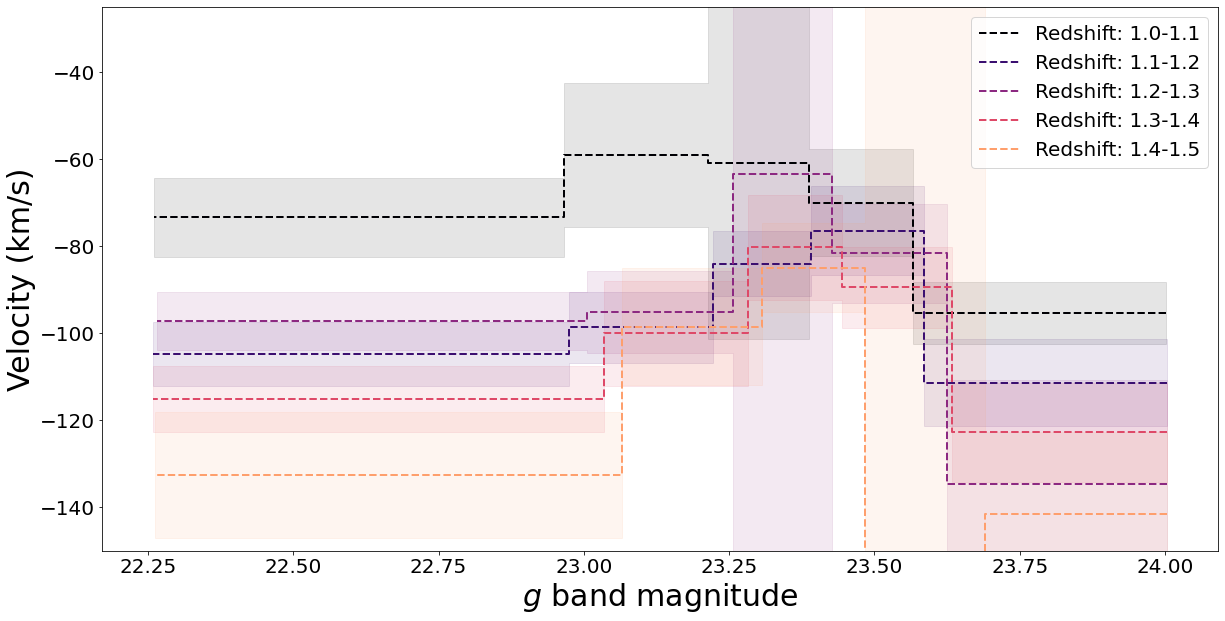

In [21]:
# files = my_path.glob("results*")
files = ['resultsELG_1.0_1.1_v0.npz', 'resultsELG_1.1_1.2_v0.npz', 'resultsELG_1.2_1.3_v0.npz', 'resultsELG_1.3_1.4_v0.npz', 'resultsELG_1.4_1.5_v0.npz'  ]
fig, ax = plt.subplots(1,1, figsize=(20,10))
viridis = cm.get_cmap("magma", 256)
newcolors = viridis(np.linspace(0, 0.8, 5))

for  i, filename in enumerate(files):
    filename = my_path / filename 
    data = np.load(filename)
    v1 = data["v1"]
    v2 = data["v2"]
    s1 = data["s1"]
    s2 = data["s2"]
    mag_bins = data["mag_bins"]
    
    zmin = float(filename.stem.split("_")[1])
    zmax = float(filename.stem.split("_")[2])
    better_step(mag_bins, (v1+v2)/2, np.std((s1+s2)/2, axis=-1), label=f"Redshift: {zmin}-{zmax}", ax=ax, ls="--", lw=2, c=newcolors[i])
    ax.set_ylim(-150,-25)
    ax.set_xlabel("$g$ band magnitude", fontsize=30)
    ax.set_ylabel("Velocity (km/s)", fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    plt.legend(fontsize=20)
    plt.savefig("../../figs/stack_plot.jpg")

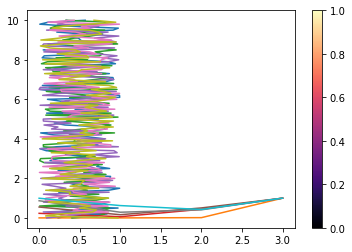

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as cmx
import matplotlib

viridis = cmx.get_cmap("magma", 256) #get a cmap and store it as 256 discrete samples
newcolors = viridis(np.linspace(0, 0.8, 5)) # select whichever chunks you want via a list/numpy array
fig, ax = plt.subplots(1,1)
for i in range(len(newcolors)):
    x = np.random.rand(101)
    y = np.linspace(0,10,101)
    ax.plot(x,y, newcolors[i]) # loop over your lines and colors to give them a dicrete color map
sm = plt.cm.ScalarMappable(cmap=viridis, norm=matplotlib.colors.Normalize(vmin=0, vmax=1))
plt.colorbar(sm)